# For CASTOR SWG-Galaxies legacy program proposal
## Instructions: FSPS SSP, age 3 Myr,  Z = 0.4 Zsol, dust=0.2, UVmag = 22 to 28, exposure time 1hr and 6hrs.

# 0 - imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ETC_grism_dev
from ETC_grism_dev import background
from ETC_grism_dev import spectrum
from ETC_grism_dev import disperser

In [121]:
from base64 import b64decode
from io import BytesIO

from IPython import get_ipython
from IPython.core.magic import register_cell_magic
import PIL


@register_cell_magic
def capture_png(line, cell):
    get_ipython().run_cell_magic(
        'capture',
        ' --no-stderr --no-stdout result',
        cell
    )
    out_paths = line.strip().split(' ')
    for output in result.outputs:
        data = output.data
        if 'image/png' in data:
            path = out_paths.pop(0)
            if not path:
                raise ValueError('Too few paths given!')
            png_bytes = data['image/png']
            if isinstance(png_bytes, str):
                png_bytes = b64decode(png_bytes)
            assert isinstance(png_bytes, bytes)
            bytes_io = BytesIO(png_bytes)
            image = PIL.Image.open(bytes_io)
            image.save(path, 'png')

# 1 - Create the direct image source (point source)

/var/folders/x4/732lcbsj15v9fwvrd_hmx_jr0000gn/T/ipykernel_8306/2128214502.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(source_image))


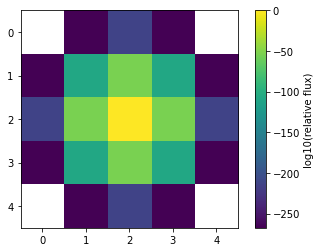

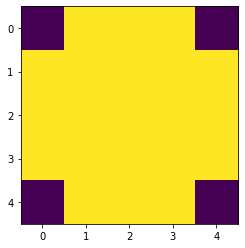

In [124]:
#%%capture_png point_source.png point_source_seg.png
#Telescope PSF FWHM
psf_fwhm = 0.15 #arcsec
pixel_scale = 0.1 #arcsec
psf_fwhm_pix = psf_fwhm/pixel_scale
x_stddev = psf_fwhm / (np.sqrt(8*np.log(2)))
y_stddev = x_stddev

box_size = 5
x,y = np.meshgrid(np.arange(box_size), np.arange(box_size))

#We assume point source follows a Gaussian2D with same FWHM as telescope PSF.
from astropy.modeling.functional_models import Gaussian2D
model = Gaussian2D(amplitude=1, x_mean=2, y_mean=2, x_stddev=x_stddev, y_stddev=y_stddev)

source_image = model(x,y)

source_seg = source_image > 0

fig1 = plt.figure()
plt.imshow(np.log10(source_image))
plt.colorbar(label='log10(relative flux)')

fig2 = plt.figure()
plt.imshow(source_seg)

# 2 - Create the source spectrum

In [23]:
from ETC_grism_dev.all_imports import sp

In [176]:
#%%capture_png test.png
#FSPS
#SSP is set with sfh=0 (default sfh in ETC_grism_dev is set to sfh=4 (delayed-tau)).
def spec(redshift=1.5):

    sp.params["sfh"] = 0 #SSP
    log_zsol = np.log10(0.4) #Z = 0.4 Zsol
    dust = 0.2 #Av mag
    fsps_params_dict = {"logzsol": log_zsol, "dust2": dust}
    source_redshift = redshift
    fsps_age = 3e-3 #Gyrs (3 Myr).

    spectrum.spectrum_from_fsps(spectrum, fsps_params_dict=fsps_params_dict, fsps_age=fsps_age, redshift=source_redshift, check=True)


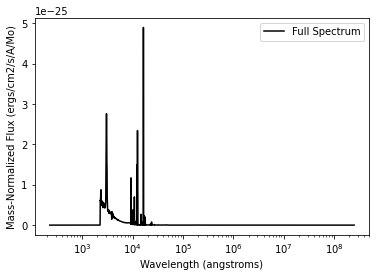

In [177]:
spec(redshift=1.5)

In [158]:
#define normalizing function to loop over

def norm_func(magnitude):
    source_mag = magnitude
    filter_channel = "uv"
    spectrum.normalize_spectrum(spectrum, magnitude=source_mag, filter_channel=filter_channel, check=True)


TARGET_FLAM, NON_NORM_FLAM, SCALING:  1.4074277929769683e-17 3.1229512856932864e-26 450672349.3973821
NORM_FLAM, NORM_FNU, NORM_MAG:  1.4074277929769686e-17 2.290867652767789 22.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  1.4074277929769683e-17 2.2908676527677887 23


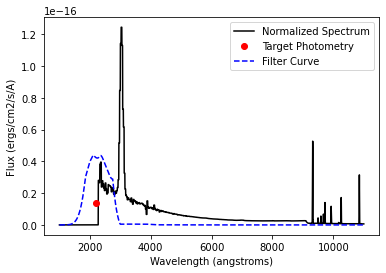

In [159]:
#Try
norm_func(magnitude=23)


# 3 - Disperse the source spectrum with the appropriate grism ("uv" or "u")

In [160]:
#disperser function to loop over
def disperse_func(source_spectrum = spectrum.spectrum, grism_channel = "uv"):

    source_spectrum = source_spectrum
    grism_channel = grism_channel 

    #disperse
    disperser.disperse(disperser, source_image=source_image, source_disperse_region=source_seg, 
                   source_spectrum=source_spectrum, grism_channel=grism_channel, check=True)


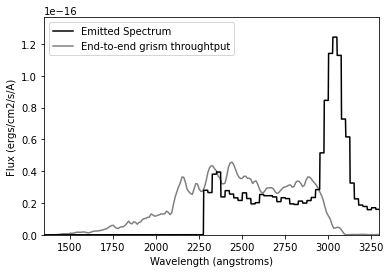

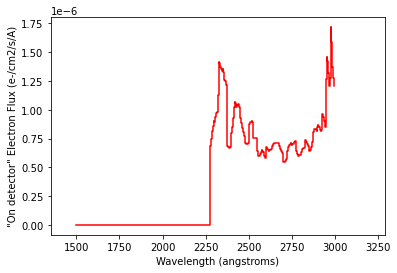

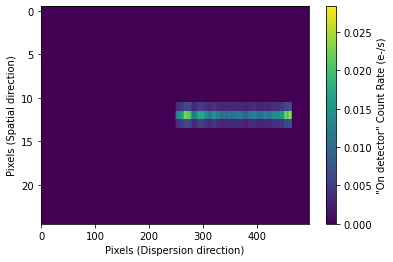

In [161]:
#try
disperse_func(source_spectrum = spectrum.spectrum, grism_channel = "uv")


# 4 - Create the (count rate) sky background

In [162]:
#The user can specify their own zodical, earthshine and geocoronal.
#By default this uses the ones also provided in the imaging ETC.
#To use your own background, 'user_zodi', 'user_earthshine', and 'user_geo' should be a path to the approriate files,
#in the same format and structure as the default ones; and 'default_sky' should be set to False.
background.recompute_sky_background(background, default_sky=True, user_zodi=None, user_earthshine=None, user_geo=None)


0

# 5 - Observe source for X seconds.

In [163]:
def expose_func(exposure_time = 1000, grism_channel="uv", Nreads=1):

    exposure_time = exposure_time #in seconds
    disperser.expose(disperser, exposure_time=exposure_time)
    #The 2D exposure (in counts [e-]), is in: 'disperser.integrated_grism_box_count'

    #Get the total signal + sky + detector noise of the exposure (in the same filter as the noiseless grism spectrum)
    Nreads = 1 #number of read-outs during total exposition.
    disperser.total_noise(disperser, exposure_time=exposure_time, filter=grism_channel, Nreads=Nreads, Nbin=1)
    #The 2D total noise is in: 'disperser.grism_noise_total'


In [164]:
#Try
expose_func(exposure_time = 1000, grism_channel="uv", Nreads=1)


# 6 - Access spectrum and noise data to get an SNR

In [165]:
def show_spec_func():
    #Show noisless spectrum (in total counts)
    #The noiseless data is in: disperser.integrated_grism_box_count
    plt.figure()
    plt.imshow(disperser.integrated_grism_box_count, aspect="auto", interpolation="none")
    plt.colorbar(label='Spectrum counts (e-)')
    plt.xlabel('Pixels (Dispersion direction)')
    plt.ylabel('Pixels (Spatial direction)')
    #1D spectrum (extracted within spatial extent of source image defined in step 1)
    plt.figure()
    box_center = int((disperser.integrated_grism_box_count.shape[0]-1) / 2)
    half_source_size = int((source_image.shape[0]-1) / 2)
    grism_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:],
                      axis=0)
    grism_1d_x = np.arange(0,len(grism_1d), 1)
    plt.plot(grism_1d_x, grism_1d, '-k')
    plt.ylabel('Spectrum counts (e-)')
    plt.xlabel('Pixels (Dispersion direction)')

    #Show signal+sky+detector noise (in total counts)
    #The total signal+sky+detector noise is in disperser.grism_noise_total
    plt.figure()
    plt.imshow(disperser.grism_noise_total, aspect="auto", interpolation="none")
    plt.colorbar(label='Noise counts (e-)')
    plt.xlabel('Pixels (Dispersion direction)')
    plt.ylabel('Pixels (Spatial direction)')
    #1D
    #The 1D noise is shown here as the error sum at each wavelength along spatial axis.
    #Also extracted within spatial extent of source image
    plt.figure()
    totnoise_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2,
                                 axis=0))
    plt.plot(grism_1d_x, totnoise_1d, '-r')
    plt.ylabel('Total Noise counts (e-)')
    plt.xlabel('Pixels (Dispersion direction)')
    return box_center, half_source_size, grism_1d_x


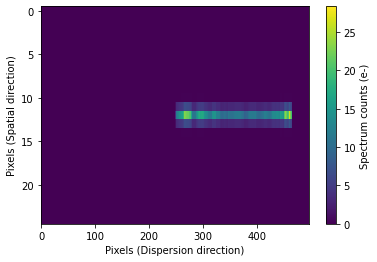

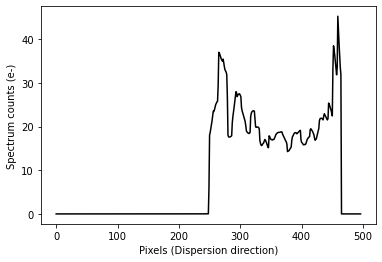

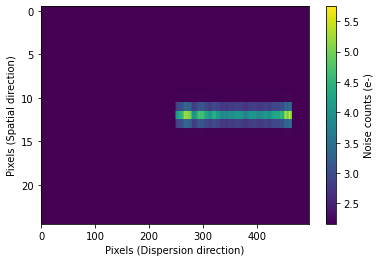

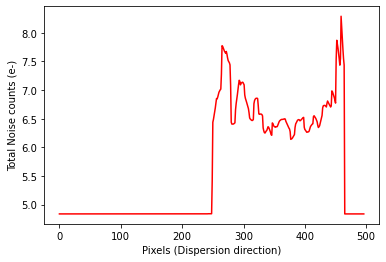

In [166]:
#Try
box_center, half_source_size, grism_1d_x = show_spec_func()

In [167]:
def show_snr_per_res_elem(box_center, half_source_size, grism_1d_x):
    #Show SNR per resolution element
    plt.figure()
    plt.imshow(disperser.integrated_grism_box_count/disperser.grism_noise_total, aspect="auto", interpolation="none")
    plt.colorbar(label='SNR')
    plt.xlabel('Pixels (Dispersion direction)')
    plt.ylabel('Pixels (Spatial direction)')


    #Show as 1D
    #1D noise taken here as the error sum at each wavelength along spatial axis.
    #Extracted within spatial extent of source image
    plt.figure()
    sum_signal_1d = np.sum(disperser.integrated_grism_box_count[box_center-half_source_size:box_center+half_source_size+1,:], 
                           axis=0)
    quad_error_1d = np.sqrt(np.sum(disperser.grism_noise_total[box_center-half_source_size:box_center+half_source_size+1,:]**2, 
                                   axis=0))
    snr_1d = sum_signal_1d / quad_error_1d
    plt.plot(grism_1d_x, snr_1d, '-k')
    plt.ylabel('SNR 1D ')
    plt.xlabel('Pixels (Dispersion direction)')


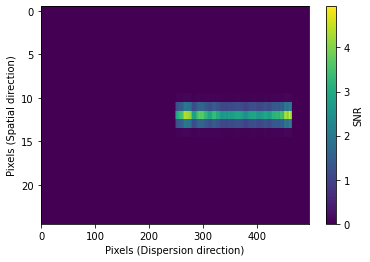

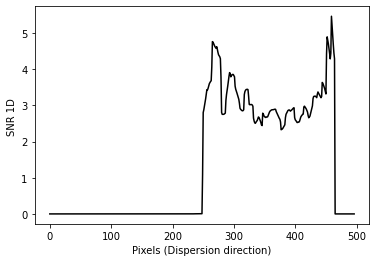

In [168]:
#Try
show_snr_per_res_elem(box_center, half_source_size, grism_1d_x)


# Loop over

In [169]:
magnitudes = np.arange(22,29,1)
magnitudes

array([22, 23, 24, 25, 26, 27, 28])

In [242]:
redshift = 2.0
exposure_time = 6 * 3600 #hours to seconds

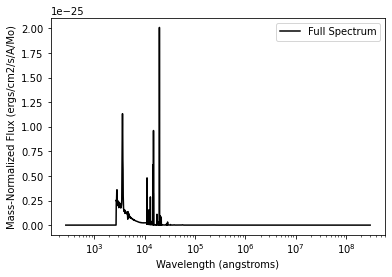

TARGET_FLAM, NON_NORM_FLAM, SCALING:  3.5352987765083095e-19 3.349864350349412e-27 105535580.15385178
NORM_FLAM, NORM_FNU, NORM_MAG:  3.5352987765083104e-19 0.057543993733715916 26.999999999999993
TARGET_FLAM, TARGET_FNU, TARGET_MAG:  3.5352987765083095e-19 0.057543993733715895 27


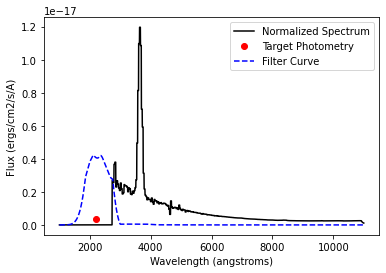

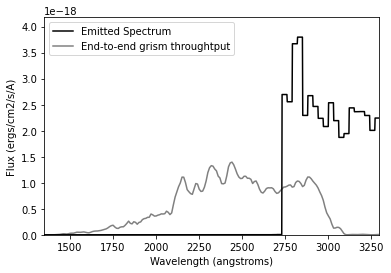

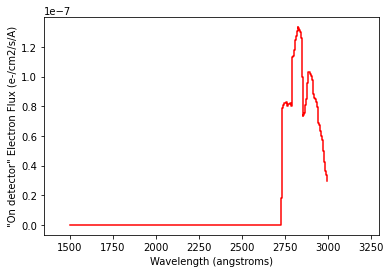

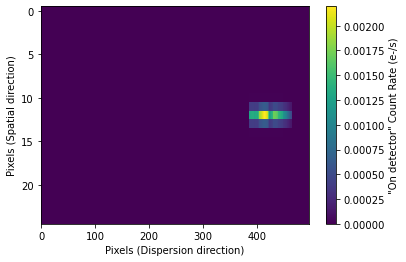

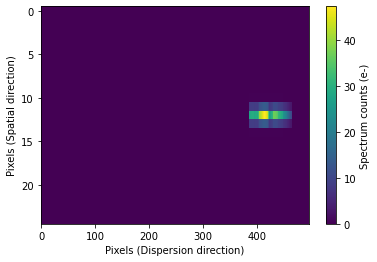

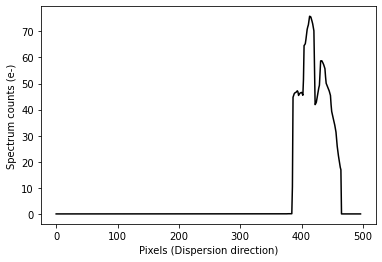

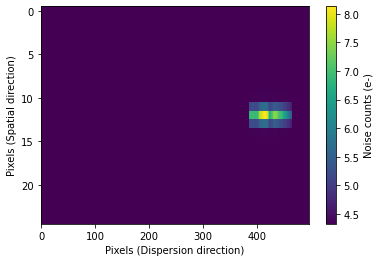

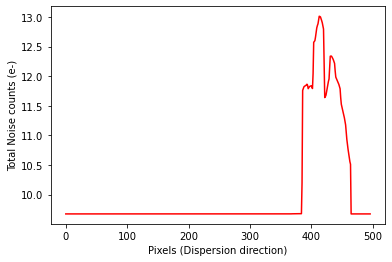

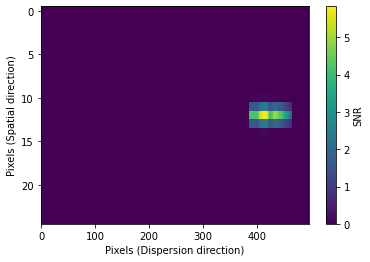

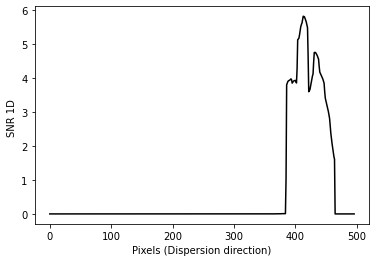

In [243]:
%%capture_png 1.png 2.png 3.png 4.png 5.png 6.png 7.png 8.png 9.png 10.png 11.png

#make spectrum
spec(redshift)

#normalize spectrum
norm_func(27)

#for gism_channel in ["uv"]:
for gism_channel in ["uv"]:
    #disperse
    disperse_func(source_spectrum = spectrum.spectrum, grism_channel = gism_channel)

    #expose
    expose_func(exposure_time = exposure_time, grism_channel=gism_channel, Nreads=1)

    #show data and noise
    box_center, half_source_size, grism_1d_x = show_spec_func()

    #show snr
    show_snr_per_res_elem(box_center, half_source_size, grism_1d_x)
